In [60]:
import MeCab
import pandas as pd
import re
from statistics import mean
import numpy as np

In [43]:
path = "Your Mecab dictinary path"
mecab = MeCab.Tagger(' -d {}'.format(path))
mecab.parse("")  # 追加

df_22 = pd.read_csv("mercari_review_22.csv", index_col=0,)
df_23 = pd.read_csv("mercari_review_23.csv", index_col=0)

In [44]:
df_22 = df_22.rename(columns={"0": "str"})
df_23 = df_23.rename(columns={"0": "str"})
sample_txt = df_23.at[1, "str"]


In [45]:
pn_df = pd.read_csv("pn_ja.dic.txt",
                     encoding="shift-jis",
                       header=None,
                         sep=":", 
                         names=("Word", "Reading", "POS", "PN"))
word_list = list(pn_df['Word'])
pn_list = list(pn_df['PN'])
pn_dict = dict(zip(word_list, pn_list))

In [46]:
def get_diclist(text):
    if '、' in text:
        text = text.replace('、', '')
    
    parsed = mecab.parse(text)      # 形態素解析結果（改行を含む文字列として得られる）
    lines = parsed.split('\n')  # 解析結果を1行（1語）ごとに分けてリストにする
    lines = lines[0:-2]         # 後ろ2行は不要なので削除
    diclist = []
    for word in lines:
        l = re.split('\t|,',word)  # 各行はタブとカンマで区切られてるので
        if not l[1] == '助詞' and not l[1] == '記号' and not l[1] == '助動詞' and not l[7] == '*':
            d = {'Surface':l[0], 'POS1':l[1], 'POS2':l[2], 'BaseForm':l[7]}
            diclist.append(d)
    return(diclist)

In [47]:
# 形態素解析結果の単語ごとdictデータにPN値を追加する関数
def add_pnvalue(diclist_old):
    diclist_new = []
    for word in diclist_old:
        base = word['BaseForm']        # 個々の辞書から基本形を取得
        if base in pn_dict:
            pn = float(pn_dict[base])  # 中身の型があれなので
        else:
            pn = 'notfound'            # その語がPN Tableになかった場合
        word['PN'] = pn
        diclist_new.append(word)
    return(diclist_new)

In [48]:
# 各ツイートのPN平均値をとる関数
def get_pnmean(diclist):
    pn_list = []
    for word in diclist:
        pn = word['PN']
        if pn != 'notfound':
            pn_list.append(pn)  # notfoundだった場合は追加もしない            
    if len(pn_list) > 0:        # 「全部notfound」じゃなければ
        pnmean = mean(pn_list)
    else:
        pnmean = 0              # 全部notfoundならゼロにする
    return(pnmean)

In [49]:
# 各ツイートのPN平均値をとる関数
def get_pnaverage(diclist):
    pn_list = []
    for word in diclist:
        pn = word['PN']
        if pn != 'notfound':
            pn_list.append(pn)  # notfoundだった場合は追加もしない            
    if len(pn_list) > 0:        # 「全部notfound」じゃなければ
        pnmean = np.average(pn_list)
    else:
        pnmean = 0              # 全部notfoundならゼロにする
    return(pnmean)

In [50]:
text_test = '昨日はラーメンを食べました．美味しかった．'

In [51]:
text_test

'昨日はラーメンを食べました．美味しかった．'

In [52]:
dl_test = get_diclist(sample_txt)
add_pnvalue(dl_test)
dl_test = add_pnvalue(dl_test)
get_pnmean(dl_test)
get_pnaverage(dl_test)

-0.55272911

# スコアによってテキストをランク付する

In [53]:
pn_text_dict = {}

for text in df_22["str"]:
    dl_test = get_diclist(text)
    dl_test = add_pnvalue(dl_test)
    score = get_pnmean(dl_test)
    
    pn_text_dict[text] = score
    
pn_text_dict = sorted(pn_text_dict.items(), key=lambda x: -x[1])

# 口コミ内容と得点を出力
# for k, v in pn_text_dict:
#     print(str(k))
#     print(str(v))
#     print()

In [54]:
df_point_23 = pd.DataFrame(pn_text_dict, columns=["内容", "点数"]).sort_values("点数").reset_index()
df_point_23["カテゴリ"] = None
# トラブル対応
def func(x):
    if "問" in x["内容"]:
        return "トラブル対応"
    elif  "対応" in x["内容"]:
        return "トラブル対応"
    elif  "フォロー" in x["内容"]:
        return "トラブル対応"
    else:
        return x["カテゴリ"]

# 商品問題
def func2(x):
    if "破損" in x["内容"]:
        return "商品問題"
    elif  "傷" in x["内容"]:
        return "商品問題"
    else:
        return x["カテゴリ"]

# 配送
def func3(x):
    if "配送" in x["内容"]:
        return "配送問題"
    elif  "発送" in x["内容"]:
        return "配送問題"
    elif  "ヤマト" in x["内容"]:
        return "配送問題"
    elif  "送料" in x["内容"]:
        return "配送問題"
    else:
        return x["カテゴリ"]

# キャンセル
def func4(x):
    if "キャンセル" in x["内容"]:
        return "キャンセル"
    else:
        return x["カテゴリ"]
    
# 制限&エラー
def func5(x):
    if "削除" in x["内容"]:
        return "制限&エラー"
    elif "ログイン" in x["内容"]:
        return "制限&エラー"
    elif "認証" in x["内容"]:
        return "制限&エラー"
    else:
        return x["カテゴリ"]
    
# def func6(x):
#     if None in x["内容"]:
#         return "その他"

df_point_23 = df_point_23.assign(カテゴリ = lambda x:x.apply(func, axis=1))
df_point_23 = df_point_23.assign(カテゴリ = lambda x:x.apply(func2, axis=1))
df_point_23 = df_point_23.assign(カテゴリ = lambda x:x.apply(func3, axis=1))
df_point_23 = df_point_23.assign(カテゴリ = lambda x:x.apply(func4, axis=1))
df_point_23 = df_point_23.assign(カテゴリ = lambda x:x.apply(func5, axis=1))
# df_point_23 = df_point_23.assign(カテゴリ = lambda x:x.apply(func6, axis=1))
df_point_23

,index,内容,点数,カテゴリ
0,305,\nトラブルがおこってメルカリに問い合わせしても対応なし\n,-0.797181,トラブル対応
1,304,\n問い合わせの対応が遅すぎる。\r\nダラダラダラダラ何日もかけてやりとりするのなぜですか？\n,-0.767037,トラブル対応
2,303,\nサロンで必要な足湯機を探していた。\r\nほぼ適正価格で、写真もあった。\r\n送られて...,-0.733151,商品問題
3,302,\n他の方も被害に合ってる様でトラブル対応が最悪 定型文ばっかり送ってきて実際に調べる気O ...,-0.726375,トラブル対応
4,301,\n赤ちゃん用の肌着が下着扱いらしくて商品削除されて利用制限もかけられた。\r\nだったら全...,-0.723796,制限&エラー
...,...,...,...,...
301,4,\n安くしてもらい、品物到着後すぐ高値転売。評価と照らし合わせると、面白いですよ。\n,-0.195626,None
302,3,\nお問い合わせしてもテンプレート貼るだけのやっつけ仕事。トラブルに解決しようとする誠意が全...,-0.191247,配送問題
303,2,\n問い合わせ電話番号がないので、名ばかりのカスタマーサポートに内容を入力して送信して回答待...,-0.190720,トラブル対応
304,1,\n他の方の出品を見て売れているのを確認してから自分も！出品したにも関わらず…\r\n利用制...,-0.187919,None


In [55]:
df_point_23[~df_point_23["カテゴリ"].isnull()]

,index,内容,点数,カテゴリ
0,305,\nトラブルがおこってメルカリに問い合わせしても対応なし\n,-0.797181,トラブル対応
1,304,\n問い合わせの対応が遅すぎる。\r\nダラダラダラダラ何日もかけてやりとりするのなぜですか？\n,-0.767037,トラブル対応
2,303,\nサロンで必要な足湯機を探していた。\r\nほぼ適正価格で、写真もあった。\r\n送られて...,-0.733151,商品問題
3,302,\n他の方も被害に合ってる様でトラブル対応が最悪 定型文ばっかり送ってきて実際に調べる気O ...,-0.726375,トラブル対応
4,301,\n赤ちゃん用の肌着が下着扱いらしくて商品削除されて利用制限もかけられた。\r\nだったら全...,-0.723796,制限&エラー
...,...,...,...,...
298,7,\n知名度が高く、皆さんがよく使われているフリマアプリでも、送料にまで10% の手数料がかか...,-0.261267,配送問題
300,5,\n送料込みにしないとほとんど売れない。利益より送料が多い。誰かに喜んでもらえるならのボラン...,-0.204104,配送問題
302,3,\nお問い合わせしてもテンプレート貼るだけのやっつけ仕事。トラブルに解決しようとする誠意が全...,-0.191247,配送問題
303,2,\n問い合わせ電話番号がないので、名ばかりのカスタマーサポートに内容を入力して送信して回答待...,-0.190720,トラブル対応


In [56]:
df_point_23[df_point_23["カテゴリ"] == "トラブル対応"]

,index,内容,点数,カテゴリ
0,305,\nトラブルがおこってメルカリに問い合わせしても対応なし\n,-0.797181,トラブル対応
1,304,\n問い合わせの対応が遅すぎる。\r\nダラダラダラダラ何日もかけてやりとりするのなぜですか？\n,-0.767037,トラブル対応
3,302,\n他の方も被害に合ってる様でトラブル対応が最悪 定型文ばっかり送ってきて実際に調べる気O ...,-0.726375,トラブル対応
6,299,\nいきなり利用停止処分を受け 問い合わせをしたけれども \r\nマニュアル通りの回答 (勿...,-0.712733,トラブル対応
8,297,\n事実と異なる言いがかりをつけられ、悪評をつけられたため事務局に相談したが、先に問い合わせ...,-0.704139,トラブル対応
...,...,...,...,...
294,11,\n民度が低いです。購入して届いたにも関わらず評価をしない購入者やなかなか受け取らない購入者...,-0.287895,トラブル対応
295,10,\n何回も問い合わせしても定型文返信でやる気なし。\r\nいつまでそんな対応で誤魔化せるか楽...,-0.287085,トラブル対応
296,9,\n明らかに人が減った。いいねすらろくにつかなくなってきた。\r\n運営の対応も日増しにずさ...,-0.285011,トラブル対応
303,2,\n問い合わせ電話番号がないので、名ばかりのカスタマーサポートに内容を入力して送信して回答待...,-0.190720,トラブル対応


<Axes: >

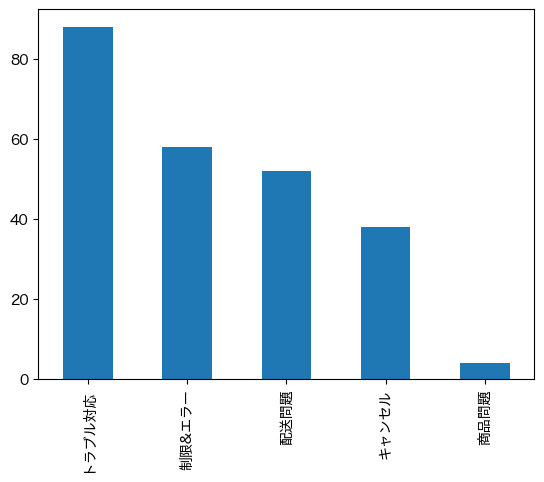

In [57]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "Hiragino sans"

df_point_23["カテゴリ"].value_counts().plot(kind="bar")


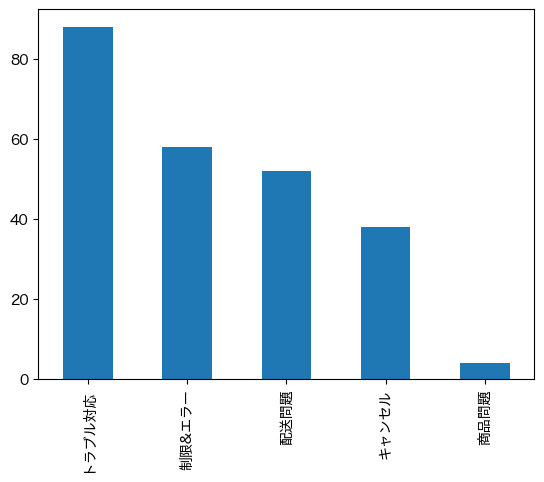

In [58]:
df_point_23["カテゴリ"].value_counts().plot(kind="bar")
plt.savefig("result/bar_chart.png", format="png", dpi=100, pad_inches=0.5, bbox_inches="tight")

In [59]:
df_point_23.to_csv("review_point_23.csv")

# 頻出単語

In [28]:
for text in df_22["str"]:
    node = mecab.parseToNode(text)
    words=[]
    while node:
        words.append(node.surface)
        node = node.next

In [26]:
#単語の数カウント
import collections
c = collections.Counter(words)
print(c.most_common(20))


[('の', 6), ('を', 6), ('が', 6), ('\r', 6), ('た', 5), ('ない', 5), ('て', 5), ('と', 5), ('し', 4), ('', 2), ('購入者', 2), ('送っ', 2), ('クレーム', 2), ('来', 2), ('ので', 2), ('は', 2), ('に', 2), ('か', 2), ('新品', 1), ('シール', 1)]


In [32]:
for text in df_22["str"]:
    node = mecab.parseToNode(text)
    words=[]
    while node:
        hinshi = node.feature.split(",")[0]
        if hinshi in ["名詞","動詞","形容詞"]:
            origin = node.feature.split(",")[6]
            words.append(origin)
        node = node.next

#単語の数カウント
import collections
c = collections.Counter(words)
print(c.most_common(100))


[('する', 5), ('購入者', 2), ('送る', 2), ('クレーム', 2), ('来る', 2), ('の', 2), ('新品', 1), ('シール', 1), ('商品', 1), ('販売', 1), ('側', 1), ('上手い', 1), ('貼れる', 1), ('代替え', 1), ('品', 1), ('ほしい', 1), ('つける', 1), ('それ', 1), ('無理', 1), ('嫌み', 1), ('よう', 1), ('事務局', 1), ('相談', 1), ('返る', 1), ('くる', 1), ('返答', 1), ('代金', 1), ('返金', 1), ('円満', 1), ('解決', 1), ('きた', 1), ('不備', 1), ('こっち', 1), ('面倒', 1), ('みる', 1), ('いける', 1), ('理解', 1), ('できる', 1), ('運営', 1), ('取引', 1), ('やり取り', 1), ('確認', 1), ('てる', 1), ('思う', 1)]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
 
sns.set(context="talk")
fig = plt.subplots(figsize=(8, 8))
 
sns.countplot(y=words,order=[i[0] for i in c.most_common(20)])

In [41]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# 口コミデータからテキストを取得する
for text in df_23["str"]:
    # 文章をトークン化し、単語ごとに分割する
    tokens = word_tokenize(text.lower())

    # ストップワードを除去する
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]


[nltk_data] Downloading package punkt to /Users/gyama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gyama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
from nltk.probability import FreqDist

# 単語の出現頻度を数える
freq_dist = FreqDist(filtered_tokens)

# 出現頻度が高い上位10件の単語を取得する
top_words = freq_dist.most_common(20)
print(top_words)

[('退会しても自分のマイナンバーや顔写真、住所や生年月日が、いつまでもメルカリに残り、削除する方法はなく、流出する可能性があるのは怖いです。その点を柔軟な方法に変えてもらえればバッチリと感じました。', 1), ('←', 1), ('マイナンバーカードと同じで１０００ポイントプレゼントとかに釣られて', 1), ('マイナンバーカードとか提出している人間が悪いだけでは。', 1), ('メルカリって別に本人確認必須でないのでもちろん本人確認していないし', 1), ('マイナンバーカードも保険証紐づけで７０００円とか、信用もない日本政府がやっているけど、', 1), ('もちろんそんなのに釣られて作ってないし', 1), ('昼間いる層は民度低いだろうな、無職とかパートだろうし', 1), ('夜とかは民度は特に低いと感じない', 1)]
